DATA DICTIONARY:
Survived - Survival (0 = No; 1 = Yes)
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
Name - Name
Sex - Sex
Age - Age
Sibsp - Number of Siblings/Spouses Aboard
Parch - Number of Parents/Children Aboard
Ticket - Ticket Number
Fare - Passenger Fare
Cabin - Cabin
Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [238]:
import os
if not os.path.exists("input/titanic/train.csv"):
    os.symlink("input/titanic/train.csv", "input/train.csv")  
    os.symlink("input/titanic/test.csv", "input/test.csv") 

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [239]:
# Load data

train_data = pd.read_csv('input/titanic/train.csv', index_col='PassengerId')
test_data = pd.read_csv('input/titanic/test.csv', index_col='PassengerId')

In [240]:
# Check features

train_data.head().T

PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05
Cabin,NaN,C85,NaN,C123,NaN


In [241]:
# Check missing values

print(train_data.isnull().sum())
print('')
print(test_data.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


In [242]:
# Names contain titles, extract titles

train_data['Title'] = train_data['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))
test_data['Title'] = train_data['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))

train_data['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

In [243]:
# Group titles by category

title_group_map = {
    "Mr": "Mr",
    "Miss": "Miss/Ms/Mlle",
    "Ms": "Miss/Ms/Mlle",
    "Mlle": "Miss/Ms/Mlle",
    "Mrs": "Mrs/Mme",
    "Mme": "Mrs/Mme",
    "Master": "Master",
    "Dr": "Officer",
    "Rev": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Capt": "Officer",
    "Don": "Nobility",
    "Lady": "Nobility",
    "Sir": "Nobility",
    "Countess": "Nobility",
    "Jonkheer": "Nobility"
}

train_data['Title_Grouped'] = train_data['Title'].map(title_group_map)
test_data['Title_Grouped'] = test_data['Title'].map(title_group_map)


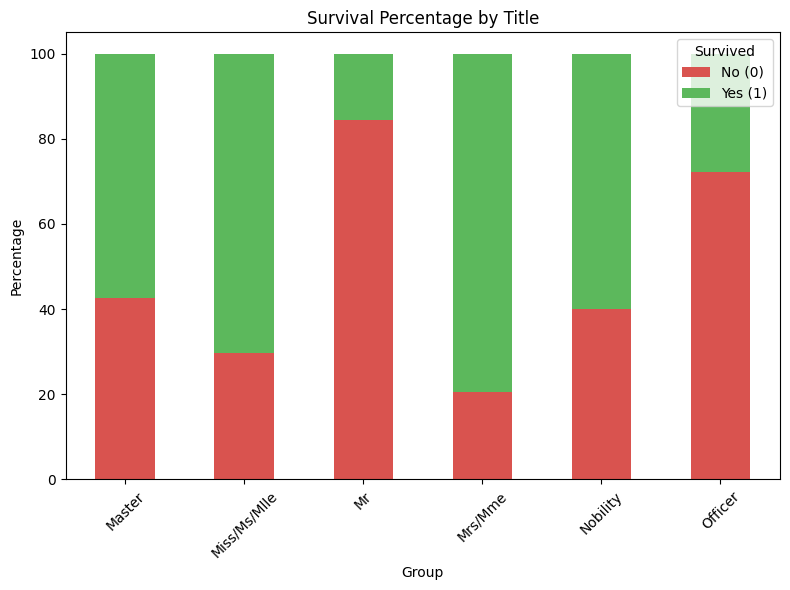

In [244]:
survival_title = train_data.groupby(['Title_Grouped', 'Survived']).size().unstack(fill_value=0)

# Convert to percentages
survival_percentages = survival_title.div(survival_title.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
survival_percentages.plot(kind='bar', stacked=True, color=['#d9534f', '#5cb85c'], figsize=(8,6))

plt.title("Survival Percentage by Title")
plt.xlabel("Group")
plt.ylabel("Percentage")
plt.legend(title='Survived', labels=['No (0)', 'Yes (1)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see that some groups have higher likelihood of survival than others which would be meaningful for our model.

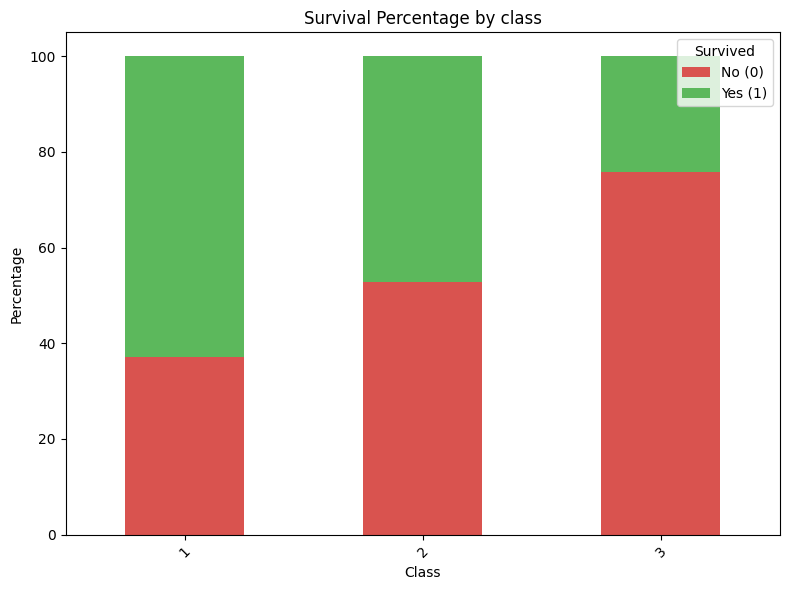

In [245]:
# Survival rate by class

survival_class = train_data.groupby(['Pclass', 'Survived']).size().unstack(fill_value=0)

# Convert to percentages
survival_percentages = survival_class.div(survival_class.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
survival_percentages.plot(kind='bar', stacked=True, color=['#d9534f', '#5cb85c'], figsize=(8,6))

plt.title("Survival Percentage by class")
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.legend(title='Survived', labels=['No (0)', 'Yes (1)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

First class had the highest chance to survive, while 3rd class the lowest, which is reasonable considering the priority probable priority treatment.

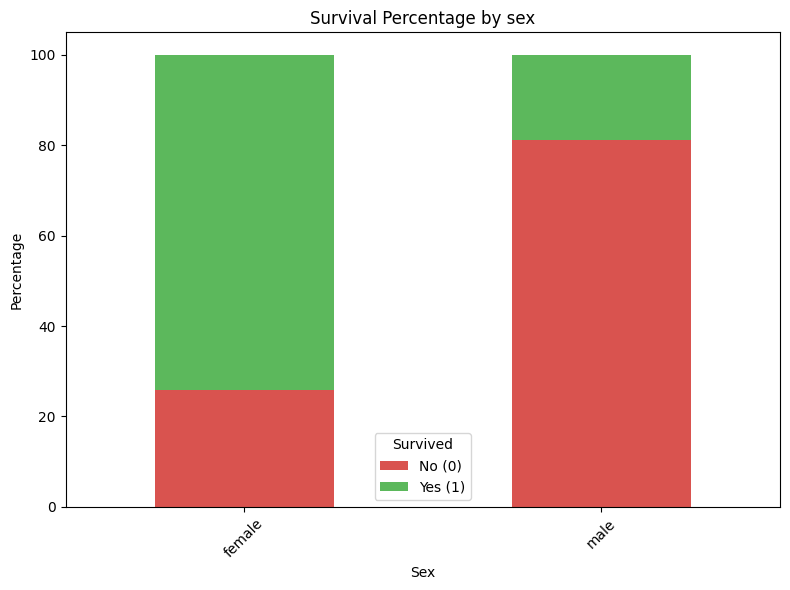

In [246]:
# Survival rate by class

survival_sex = train_data.groupby(['Sex', 'Survived']).size().unstack(fill_value=0)

# Convert to percentages
survival_percentages = survival_sex.div(survival_sex.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
survival_percentages.plot(kind='bar', stacked=True, color=['#d9534f', '#5cb85c'], figsize=(8,6))

plt.title("Survival Percentage by sex")
plt.xlabel("Sex")
plt.ylabel("Percentage")
plt.legend(title='Survived', labels=['No (0)', 'Yes (1)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most of the fatalities were male, considering women and children were the first to board the lifeboats. There is a potential benefit of trying to figure out how many were male children but since we're missing a hefty portion of values for age, we will not do that.

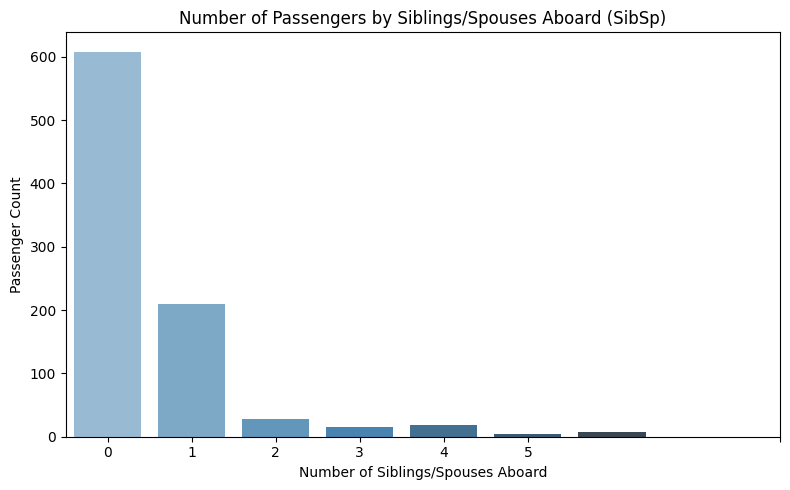

In [247]:
# SibSp - Siblings/Spouse

sibsp_counts = train_data['SibSp'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=sibsp_counts.index, y=sibsp_counts.values, palette="Blues_d")

plt.title("Number of Passengers by Siblings/Spouses Aboard (SibSp)")
plt.xlabel("Number of Siblings/Spouses Aboard")
plt.ylabel("Passenger Count")
plt.xticks(sibsp_counts.index)
plt.tight_layout()
plt.show()

Most of the travellers were aboard with no siblings nor spouse.

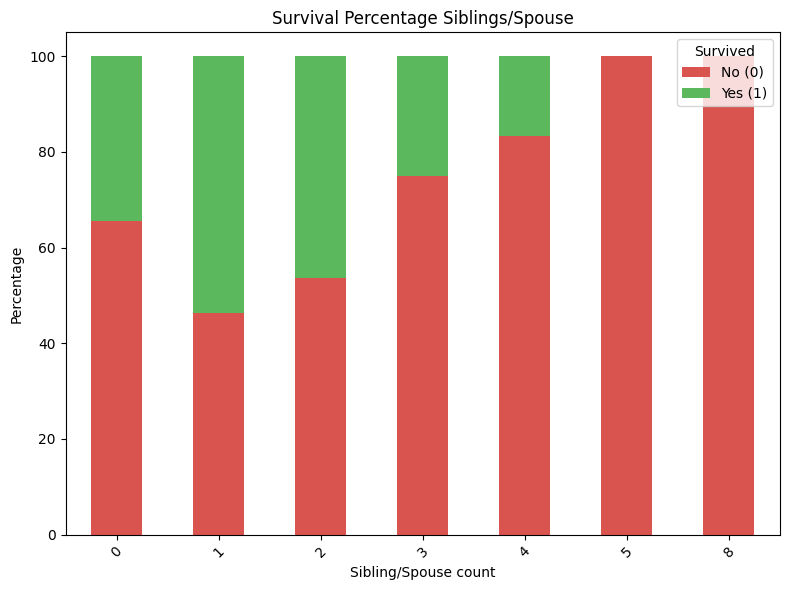

In [248]:
# Sibling/Spouse number to survival ratio

survival_sibsp = train_data.groupby(['SibSp', 'Survived']).size().unstack(fill_value=0)

# Convert to percentages
survival_percentages = survival_sibsp.div(survival_sibsp.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
survival_percentages.plot(kind='bar', stacked=True, color=['#d9534f', '#5cb85c'], figsize=(8,6))

plt.title("Survival Percentage Siblings/Spouse")
plt.xlabel("Sibling/Spouse count")
plt.ylabel("Percentage")
plt.legend(title='Survived', labels=['No (0)', 'Yes (1)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

People with 1/2 siblings or a spouse had a higher chance of survival.

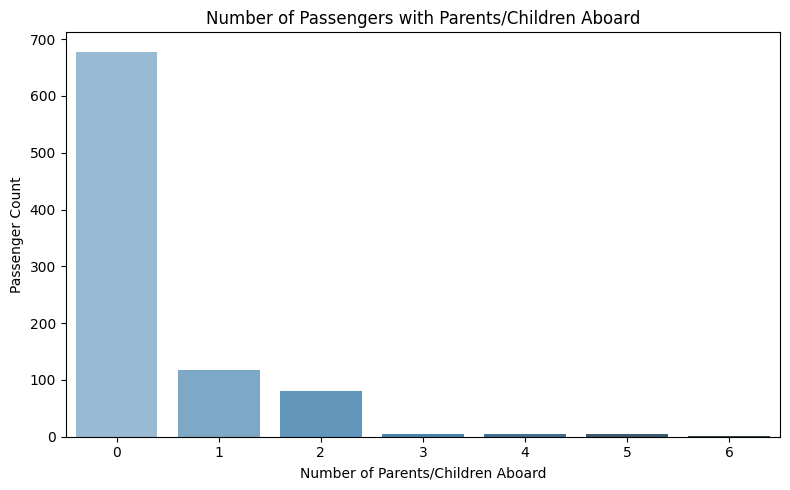

In [249]:
# Parch - Children/Parents

parch_counts = train_data['Parch'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=parch_counts.index, y=parch_counts.values, palette="Blues_d")

plt.title("Number of Passengers with Parents/Children Aboard")
plt.xlabel("Number of Parents/Children Aboard")
plt.ylabel("Passenger Count")
plt.xticks(parch_counts.index)
plt.tight_layout()
plt.show()

Most of the travellers were aboard with no parents nor children.

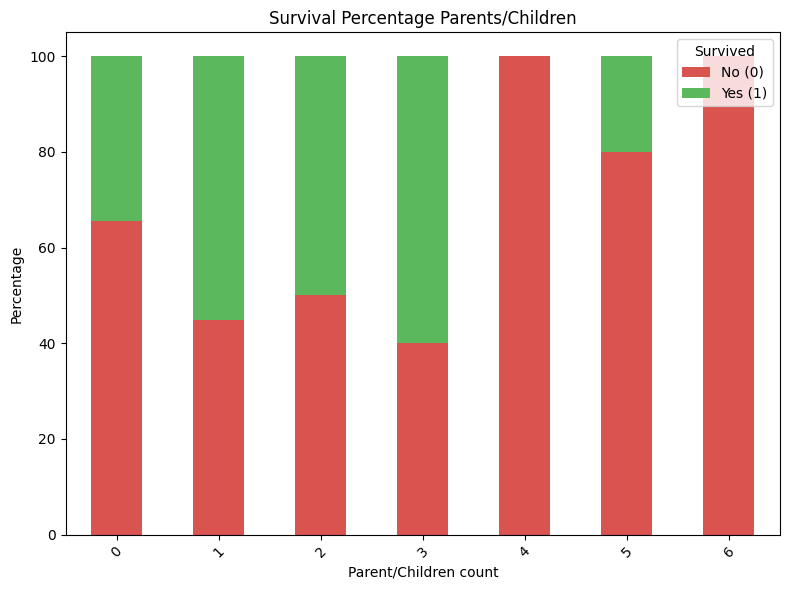

In [250]:
# Parent/Children number to survival ratio

survival_parch = train_data.groupby(['Parch', 'Survived']).size().unstack(fill_value=0)

# Convert to percentages
survival_percentages = survival_parch.div(survival_parch.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
survival_percentages.plot(kind='bar', stacked=True, color=['#d9534f', '#5cb85c'], figsize=(8,6))

plt.title("Survival Percentage Parents/Children")
plt.xlabel("Parent/Children count")
plt.ylabel("Percentage")
plt.legend(title='Survived', labels=['No (0)', 'Yes (1)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

People with 1-3 parents/children aboard had a higher chance of survival.

In [251]:
# Create new feature 'FamilySize' by combining SibSp and Parch

train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

train_data.head()



,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_Grouped,FamilySize
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs/Mme,2
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss/Ms/Mlle,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs/Mme,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr,1


In [252]:
# Drop unecessary features

train_data = train_data.drop(['Ticket', 'Title', 'Name', 'Cabin'], axis=1)
test_data = test_data.drop(['Ticket', 'Title', 'Name', 'Cabin'], axis=1)

In [253]:
# Check data

train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title_Grouped,FamilySize
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Mr,2
2,1,1,female,38.0,1,0,71.2833,C,Mrs/Mme,2
3,1,3,female,26.0,0,0,7.9250,S,Miss/Ms/Mlle,1
4,1,1,female,35.0,1,0,53.1000,S,Mrs/Mme,2
5,0,3,male,35.0,0,0,8.0500,S,Mr,1


In [254]:
# Group-based imputation for missing age values

def fill_age(row, median_ages, overall_median):
    if pd.isna(row['Age']):
        key = (row['Sex'], row['Title_Grouped'], row['Pclass'])
        return median_ages.get(key, overall_median)
    else:
        return row['Age']


overall_median = train_data['Age'].median()
train_data['Age'] = train_data.apply(lambda row: fill_age(row, median_ages, overall_median), axis=1)
test_data['Age'] = test_data.apply(lambda row: fill_age(row, median_ages, overall_median), axis=1)


In [255]:
# Find the most frequent embarkation port
most_common_embarked = train_data['Embarked'].mode()[0]

# Fill missing values
train_data['Embarked'].fillna(most_common_embarked, inplace=True)


C:\Users\brainshivers\AppData\Local\Temp\ipykernel_18024\1268480463.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Embarked'].fillna(most_common_embarked, inplace=True)


In [256]:
# Calculate the mean Fare from test_data (or train_data if preferred)
fare_mean = test_data['Fare'].mean()

# Fill missing Fare values
test_data['Fare'].fillna(fare_mean, inplace=True)


C:\Users\brainshivers\AppData\Local\Temp\ipykernel_18024\1677864283.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Fare'].fillna(fare_mean, inplace=True)


In [ ]:
# Convert categorical variables to numeric

for df in [train_data, test_data]:
    # Get all columns of object or category type
    obj_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Include Pclass manually if needed
    if 'Pclass' in df.columns:
        obj_cols.append('Pclass')

    # One-hot encode all selected columns
    df_dummies = pd.get_dummies(df[obj_cols], drop_first=False)

    # Drop the original object columns
    df.drop(obj_cols, axis=1, inplace=True)

    # Join dummies
    df[df_dummies.columns] = df_dummies


ValueError: Length of 'prefix' (4) did not match the length of the columns being encoded (3).

In [ ]:
# Look for missing values

print(train_data.isnull().sum())
print('')
print(test_data.isnull().sum())

Survived                      0
Age                           0
SibSp                         0
Parch                         0
Fare                          0
FamilySize                    0
Pclass_1                      0
Pclass_2                      0
Pclass_3                      0
Sex_female                    0
Sex_male                      0
Embarked_C                    0
Embarked_Q                    0
Embarked_S                    0
Title_Grouped_Master          0
Title_Grouped_Miss/Ms/Mlle    0
Title_Grouped_Mr              0
Title_Grouped_Mrs/Mme         0
Title_Grouped_Nobility        0
Title_Grouped_Officer         0
dtype: int64

Age                           0
SibSp                         0
Parch                         0
Fare                          0
FamilySize                    0
Pclass_1                      0
Pclass_2                      0
Pclass_3                      0
Sex_female                    0
Sex_male                      0
Embarked_C                

In [ ]:
X = train_data.drop('Survived',axis=1)
y = train_data['Survived']
X_test = test_data

In [ ]:
# Splitting data

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
# Model selection

model = RandomForestClassifier(
    n_estimators=100,         # Number of trees
    max_depth=5,              # Controls overfitting;
    min_samples_split=5,      # Minimum samples to split a node
    min_samples_leaf=3,       # Minimum samples at a leaf node
    max_features='sqrt',      # Consider sqrt of features at each split
    random_state=1,           # For reproducibility
    class_weight='balanced',  # Handle survival class imbalance
    oob_score=True,           # Out-of-bag validation score
    n_jobs=-1                 # Use all CPU cores
)

model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,5
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [ ]:
# Cross-validation

scores = cross_val_score(model, X, y, cv=5)
print("CV Accuracy:", scores.mean())

CV Accuracy: 0.815956311593748


In [259]:
# Making predictions

predictions = model.predict(X_test)


In [261]:
# Creating submission

submission = pd.DataFrame({
    'PassengerId': test_data.sort_index,
    'Survived': predictions
})

submission.to_csv('output/submission.csv', index=False)
